# Collaborative filtering

## Load libraries

In [1]:
import pandas as pd
import dexplot
import random

## Read data

In [2]:
ratings = pd.read_csv('./goodbooks-10k-1.0/ratings.csv')
#books = pd.read_csv('./goodbooks-10k-1.0/books.csv')
display(ratings.head(5))

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [3]:
print(f'Number of ratings is {len(ratings)}')
print(f'Number of users who rated at least one book is {len(ratings.user_id.unique())}')

Number of ratings is 5976479
Number of users who rated at least one book is 53424


There is almost a 6 million ratings - it would be hard to process such an amount of data. We have to reduce the number of observations.

Let's see the statistics for number of books rated per user:

In [4]:
def grouping(data, col_name):
    return data.groupby(col_name)['rating'].count()

In [5]:
def check_ratings(data, col_name):
    data_grouped = grouping(data, col_name)
    title = 'Number of ratings per '+ str(col_name[:-3])
    display(dexplot.hist(val='rating',data=data_grouped, title=title, cmap='plasma'))
    print('Statistics for dataframe grouped by '+ str(col_name) +':')
    print(data_grouped.describe())

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


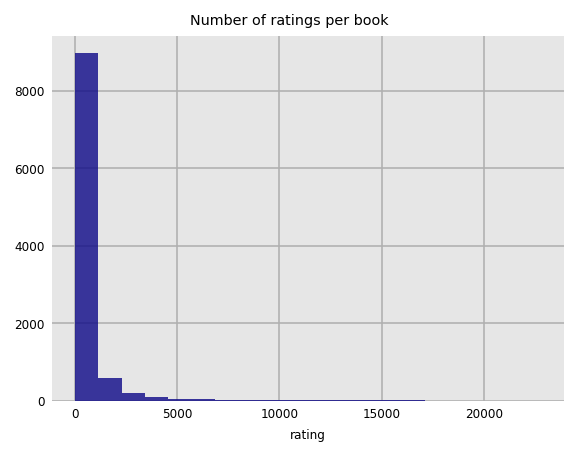

Statistics for dataframe grouped by book_id:
count    10000.000000
mean       597.647900
std       1267.289788
min          8.000000
25%        155.000000
50%        248.000000
75%        503.000000
max      22806.000000
Name: rating, dtype: float64


In [6]:
check_ratings(ratings, 'book_id')

Let's remove books which has less than 248 reviews.

In [7]:
grouped_by_book = grouping(ratings, 'book_id')
ratings = ratings[ratings.book_id.isin(grouped_by_book[grouped_by_book >=400].index)]
ratings.shape

(4614057, 3)

Let's see the statistics for number of ratings per user:

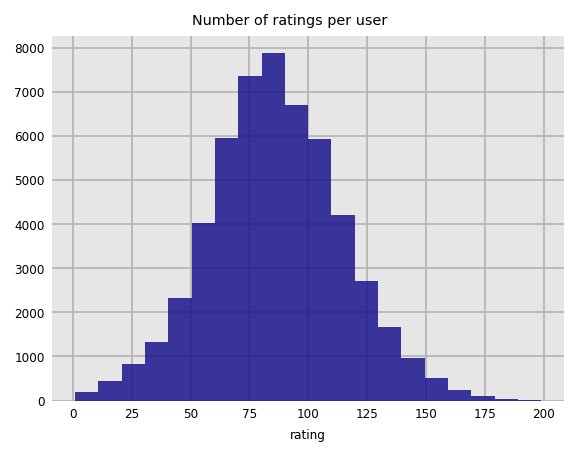

Statistics for dataframe grouped by user_id:
count    53424.000000
mean        86.366745
std         28.334976
min          1.000000
25%         68.000000
50%         86.000000
75%        104.000000
max        199.000000
Name: rating, dtype: float64


In [8]:
check_ratings(ratings, 'user_id')

Let's remove users which rated less than 100 books.

In [9]:
grouped_by_user = grouping(ratings, 'user_id')
ratings = ratings[ratings.user_id.isin(grouped_by_user[grouped_by_user >=120].index)]
ratings.shape

(849199, 3)

Check if there are any NaNs in data

In [10]:
ratings.isna().sum()

user_id    0
book_id    0
rating     0
dtype: int64

Check if there is any users who give two ratings to the same book.

In [11]:
ratings.duplicated(['user_id','book_id']).sum()

0

In [12]:
ratings.rating.describe()

count    849199.000000
mean          3.857025
std           1.010149
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [13]:
print(f'Total number of users is {len(ratings.user_id.unique())}.')
print(f'Total number of rated books is {len(ratings.book_id.unique())}.')
print(f'Total number of ratings is {len(ratings)}.')

Total number of users is 6280.
Total number of rated books is 3164.
Total number of ratings is 849199.


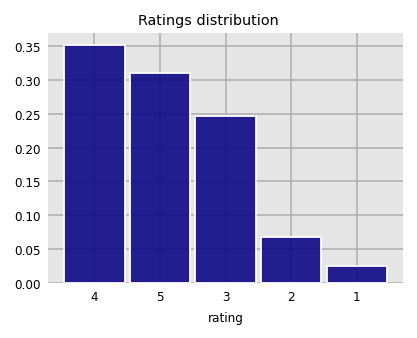

In [14]:
dexplot.count(val='rating', data=ratings, normalize= True, title='Ratings distribution', cmap='plasma')

The most common rating is 4. 

For the prediction I will use the library Surprise.

In [15]:
from surprise import Reader, Dataset
from surprise.model_selection import GridSearchCV
from surprise.prediction_algorithms import KNNBasic,KNNBaseline,KNNWithZScore,KNNWithMeans
from surprise import accuracy

In [16]:
random.seed(6)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings, reader)
raw_ratings = data.raw_ratings
train = data

In [17]:
random.shuffle(raw_ratings)

Divide data into train and test

In [18]:
train_size = int(.8 * len(raw_ratings)) 
train_raw_ratings = raw_ratings[:train_size]                             
test_raw_ratings = raw_ratings[train_size:]                                 
train.raw_ratings = train_raw_ratings

In [19]:
data.raw_ratings = train_raw_ratings

In [20]:
model_dict = {'KNNBasic': KNNBasic,'KNNBaseline': KNNBaseline,
              'KNNWithZScore': KNNWithZScore, 'KNNWithMeans' :KNNWithMeans}
param_grid = {'k': [20], 
              'sim_options': {'user_based': [False]}
             }
results = []

In [23]:
for name, model in model_dict.items():
    grid = GridSearchCV(model,param_grid, cv = 2)
    grid.fit(data)
    print(f' Best params for model {str(model)} are {grid.best_params}')
    results.append((name, grid.best_estimator['rmse'], grid.best_estimator['rmse']))

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
 Best params for model <class 'surprise.prediction_algorithms.knns.KNNBasic'> are {'rmse': {'k': 20, 'sim_options': {'user_based': False}}, 'mae': {'k': 20, 'sim_options': {'user_based': False}}}
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
 Best params for model <class 'surprise.prediction_algorithms.knns.KNNBaseline'> are {'rmse': {'k': 20, 'sim_options': {'user_based': False}}, 'mae': {'k': 20, 'sim_options': {'user_based': False}}}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
 Best params for model <class 'surprise.prediction_algorithms.knns.KNNWithZScore'> are {'rmse': {'k': 20,

In [27]:
results

[('KNNBasic',
  <surprise.prediction_algorithms.knns.KNNBasic at 0x7f1b0175fa90>),
 ('KNNBaseline',
  <surprise.prediction_algorithms.knns.KNNBaseline at 0x7f1b034e8bb0>),
 ('KNNWithZScore',
  <surprise.prediction_algorithms.knns.KNNWithZScore at 0x7f1b034e8b50>),
 ('KNNBasic',
  <surprise.prediction_algorithms.knns.KNNBasic at 0x7f1b04587550>),
 ('KNNBaseline',
  <surprise.prediction_algorithms.knns.KNNBaseline at 0x7f1b652ac490>),
 ('KNNWithZScore',
  <surprise.prediction_algorithms.knns.KNNWithZScore at 0x7f1aed365940>),
 ('KNNWithMeans',
  <surprise.prediction_algorithms.knns.KNNWithMeans at 0x7f1b04587fa0>)]

In [26]:
rmse = []
mae = []
for name, model,_ in results:
    print(name)                                                     
                                                                           
    # now test on the trainset                                                 
    trainset = data.build_full_trainset()
    model.fit(trainset)                                          

    # Compute biased accuracy on A
    predictions = model.test(trainset.build_testset())
    print('Biased accuracy on A,', end='   ')
    accuracy.rmse(predictions)

    # Compute unbiased accuracy on B
    testset = data.construct_testset(test_raw_ratings)  # testset is now the set B
    predictions = model.test(testset)
    print('Unbiased accuracy on B,', end=' ')
    accuracy.rmse(predictions)                                                                                        
    rmse_score = accuracy.rmse(predictions)
    mae_score = accuracy.mae(predictions)
    print("RMSE: {}".format(rmse_score))
    print("MAE: {}".format(mae_score))
    rmse.append(rmse_score)
    mae.append(mae_score)

KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.6073
Unbiased accuracy on B, RMSE: 0.8879
RMSE: 0.8879
MAE:  0.6904
RMSE: 0.8879321891035324
MAE: 0.6904194959575907
KNNBaseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.6067
Unbiased accuracy on B, RMSE: 0.8659
RMSE: 0.8659
MAE:  0.6729
RMSE: 0.8658745535748417
MAE: 0.6728855922525602
KNNWithZScore
Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.6086
Unbiased accuracy on B, RMSE: 0.8713
RMSE: 0.8713
MAE:  0.6757
RMSE: 0.8713008773631512
MAE: 0.6756551652621126
KNNBasic
Computing the msd similarity matrix...
Done computing similarity matrix.
Biased accuracy on A,   RMSE: 0.6073
Unbiased accuracy on B, RMSE: 0.8879
RMSE: 0.8879
MAE:  0.6904
RMSE: 0.8879321891035324
MAE: 0.6904194959575907
KNNBaseline
Estimating biases using a

KeyboardInterrupt: 

In [29]:
results

[('KNNBasic',
  <surprise.prediction_algorithms.knns.KNNBasic at 0x7f1b0175fa90>),
 ('KNNBaseline',
  <surprise.prediction_algorithms.knns.KNNBaseline at 0x7f1b034e8bb0>),
 ('KNNWithZScore',
  <surprise.prediction_algorithms.knns.KNNWithZScore at 0x7f1b034e8b50>),
 ('KNNBasic',
  <surprise.prediction_algorithms.knns.KNNBasic at 0x7f1b04587550>),
 ('KNNBaseline',
  <surprise.prediction_algorithms.knns.KNNBaseline at 0x7f1b652ac490>),
 ('KNNWithZScore',
  <surprise.prediction_algorithms.knns.KNNWithZScore at 0x7f1aed365940>),
 ('KNNWithMeans',
  <surprise.prediction_algorithms.knns.KNNWithMeans at 0x7f1b04587fa0>)]

In [28]:
import pandas as pd
d = {'rmse': rmse, 
     'mae': mae
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['KNNBasic','KNNBaseline',
              'KNNWithZScore','KNNWithMeans'])
df

,Method,rmse,mae
0,KNNBasic,0.887932,0.690419
1,KNNBaseline,0.865875,0.672886
2,KNNWithZScore,0.871301,0.675655
3,KNNWithMeans,0.887932,0.690419


In [34]:
color = (df.rmse == df.rmse.min()).map({True: 'background-color: yellow', False: 'background_color: white'})
df.style.apply(lambda s: color)

,Method,rmse,mae
0,KNNBasic,0.887932,0.690419
1,KNNBaseline,0.865875,0.672886
2,KNNWithZScore,0.871301,0.675655
3,KNNWithMeans,0.887932,0.690419


Top n-recommendations

In [36]:
from collections import defaultdict

In [48]:
def get_top_n(predictions, n=10):


    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

53057 [774, 752, 163, 214, 30, 60, 147, 1720, 393, 62]
47876 [102, 189, 766, 2, 168, 516, 532, 140, 1698, 365]
11154 [144, 143, 2374, 325, 458, 316, 230, 1920, 471, 3889]
18169 [1374, 2677, 110, 1394, 894, 565, 2210, 1693, 1034, 3298]
9927 [142, 3772, 157, 198, 339, 179, 494, 1670, 211, 378]
15498 [31, 11, 2875, 140, 520, 2314, 12, 172, 972, 230]
27585 [24, 1010, 2, 780, 394, 31, 23, 854, 160, 398]
4084 [155, 1181, 17, 1067, 594, 243, 1390, 81, 89, 19]
35824 [1462, 47, 1310, 87, 1256, 142, 3776, 46, 883, 67]
8477 [31, 195, 66, 150, 2010, 100, 117, 198, 129, 119]
901 [11, 1, 721, 25, 318, 12, 304, 216, 57, 1752]
41042 [550, 285, 1786, 146, 659, 16, 848, 179, 101, 1068]
21778 [4, 144, 1888, 17, 385, 8, 512, 76, 350, 190]
18461 [307, 960, 31, 39, 2807, 3673, 23, 510, 2154, 1629]
18184 [27, 1022, 1308, 294, 214, 1678, 47, 1027, 1668, 933]
15267 [312, 704, 285, 43, 154, 1644, 100, 90, 193, 46]
27217 [119, 124, 295, 459, 1, 205, 534, 1474, 273, 407]
2166 [25, 155, 84, 184, 1258, 3387, 253, 6

19062 [769, 225, 534, 4, 39, 19, 593, 427, 154, 316]
32814 [1320, 1, 196, 1205, 520, 103, 13, 270, 157, 1486]
951 [360, 219, 3519, 157, 405, 110, 59, 593, 346, 444]
20229 [366, 1047, 1487, 721, 47, 2078, 272, 200, 318, 1707]
7840 [339, 102, 58, 2274, 199, 361, 1217, 590, 1103, 3223]
44694 [2459, 39, 1741, 27, 1058, 317, 768, 17, 3612, 758]
11599 [215, 21, 523, 948, 867, 1644, 2738, 17, 47, 150]
27920 [3091, 258, 437, 1158, 2796, 642, 265, 47, 318, 11]
24642 [2821, 76, 1562, 1331, 10, 3484, 971, 48, 830, 60]
26485 [27, 47, 10, 94, 2579, 104, 1081, 1435, 906, 195]
12605 [1, 444, 1158, 317, 271, 249, 20, 408, 483, 30]
35728 [102, 23, 70, 320, 1539, 3269, 572, 1199, 317, 1044]
12776 [144, 2648, 997, 344, 316, 1319, 87, 467, 33, 361]
16543 [18, 39, 27, 25, 17, 189, 958, 66, 378, 67]
48665 [466, 2093, 681, 196, 1826, 2326, 177, 119, 2475, 272]
2288 [1895, 297, 50, 4, 27, 37, 520, 229, 3808, 115]
47014 [4, 19, 7, 66, 17, 188, 262, 16, 253, 2112]
6541 [125, 296, 1980, 2409, 312, 751, 608, 157,

43760 [4, 307, 39, 2724, 345, 9, 1094, 69, 1897, 29]
13182 [2043, 168, 665, 1607, 3000, 3200, 1248, 1768, 2489, 3184]
23619 [31, 1, 516, 476, 1666, 216, 317, 95, 113, 2089]
32941 [793, 18, 19, 291, 198, 31, 1456, 38, 133, 17]
5960 [4, 50, 1, 739, 66, 39, 42, 37, 612, 54]
34688 [4, 757, 31, 265, 37, 1176, 3776, 1041, 198, 216]
40975 [4271, 2892, 1717, 265, 2, 3080, 402, 65, 395, 1885]
22319 [2346, 1419, 840, 168, 321, 154, 125, 150, 94, 688]
21285 [47, 184, 1, 987, 2625, 181, 198, 17, 642, 80]
14543 [673, 626, 855, 1714, 285, 704, 2584, 808, 311, 1411]
28297 [4, 769, 402, 10, 829, 54, 446, 258, 219, 133]
41733 [364, 953, 59, 176, 295, 86, 54, 2515, 25, 97]
11868 [248, 230, 471, 839, 1167, 2052, 618, 28, 1112, 162]
13339 [466, 739, 1471, 1, 757, 612, 1493, 68, 321, 2796]
3935 [18, 100, 344, 24, 663, 380, 1153, 1102, 13, 19]
21989 [24, 1176, 768, 13, 36, 37, 2269, 129, 225, 514]
817 [15, 109, 89, 17, 663, 37, 191, 140, 374, 494]
1346 [27, 18, 19, 21, 189, 15, 54, 101, 2123, 66]
10228 [2, 

31425 [4, 1158, 19, 516, 291, 864, 669, 54, 620, 1752]
16941 [89, 2255, 841, 664, 377, 1501, 1070, 100, 130, 361]
35964 [24, 18, 2713, 274, 3857, 512, 243, 9, 1561, 670]
9872 [4, 540, 402, 36, 189, 1833, 2644, 103, 1679, 270]
49248 [964, 172, 1223, 248, 24, 863, 115, 28, 151, 21]
30487 [144, 70, 1552, 365, 36, 3484, 2975, 274, 289, 48]
42613 [4, 464, 863, 2892, 3051, 1402, 1656, 1648, 198, 46]
12172 [704, 422, 231, 59, 216, 57, 46, 195, 4, 358]
49644 [1256, 117, 126, 4709, 466, 2260, 265, 2700, 268, 124]
5009 [24, 77, 23, 779, 133, 2004, 219, 297, 1960, 526]
30944 [1380, 192, 191, 50, 608, 358, 54, 276, 80, 377]
14437 [24, 184, 480, 542, 1011, 209, 140, 92, 2074, 93]
44499 [808, 155, 2640, 1682, 180, 1155, 480, 4565, 481, 297]
28178 [1274, 958, 2467, 2413, 994, 579, 288, 707, 2475, 786]
34195 [189, 2018, 769, 133, 161, 2931, 1031, 1509, 131, 1320]
41339 [89, 141, 1626, 472, 767, 1341, 1760, 312, 289, 23]
3796 [18, 24, 27, 66, 311, 142, 159, 150, 540, 119]
10318 [666, 6, 1827, 21, 535, 

17668 [135, 1419, 110, 2412, 1, 168, 936, 177, 165, 1261]
45965 [1898, 36, 102, 12, 2241, 65, 1074, 1476, 1977, 1774]
24880 [89, 2, 1349, 126, 427, 1650, 129, 2123, 1, 738]
18620 [1909, 142, 125, 317, 1216, 613, 442, 901, 291, 60]
27294 [215, 21, 1099, 142, 1349, 2103, 291, 289, 1569, 33]
50149 [161, 2, 10, 76, 11, 87, 198, 697, 118, 30]
27663 [161, 391, 125, 189, 103, 7, 493, 19, 3101, 1041]
25317 [189, 161, 150, 33, 1234, 343, 84, 179, 1581, 118]
52938 [225, 24, 610, 613, 98, 262, 1326, 12, 1644, 1068]
12811 [2775, 2535, 1411, 144, 471, 325, 779, 146, 440, 1220]
26146 [267, 39, 23, 110, 189, 19, 72, 2722, 7, 133]
4480 [337, 512, 184, 601, 67, 1695, 826, 402, 1279, 176]
18468 [4, 12, 17, 10, 179, 183, 2699, 153, 114, 186]
34544 [2, 87, 36, 2813, 46, 222, 749, 1551, 1217, 149]
8501 [267, 112, 440, 359, 185, 642, 140, 412, 349, 2476]
30794 [1108, 1223, 769, 1717, 225, 2655, 958, 337, 545, 1695]
8090 [540, 15, 681, 779, 204, 245, 353, 653, 1569, 417]
40827 [98, 2, 11, 15, 318, 112, 31, 1

51606 [2, 4, 6, 102, 85, 1077, 2095, 1492, 1548, 46]
51746 [2339, 196, 1679, 436, 234, 131, 1503, 225, 3551, 1657]
46177 [444, 762, 2411, 15, 104, 270, 398, 311, 101, 3131]
22334 [2798, 31, 672, 125, 444, 13, 618, 304, 109, 123]
47235 [1374, 779, 311, 307, 2407, 2493, 86, 1695, 242, 1731]
45216 [444, 27, 161, 31, 3628, 24, 373, 14, 2382, 142]
53130 [760, 2955, 31, 18, 24, 110, 554, 43, 717, 175]
45588 [192, 161, 18, 67, 10, 510, 283, 540, 599, 409]
8797 [192, 2992, 1869, 3988, 1957, 134, 195, 171, 12, 419]
4359 [23, 11, 416, 4, 150, 119, 68, 2835, 43, 487]
25932 [225, 65, 33, 271, 121, 30, 178, 534, 1331, 295]
18550 [110, 87, 1210, 158, 117, 3127, 346, 2497, 271, 1882]
43217 [39, 110, 23, 1380, 480, 191, 165, 1160, 1113, 213]
1571 [168, 709, 133, 1014, 572, 311, 13, 2810, 46, 2047]
14061 [250, 87, 31, 66, 106, 1714, 216, 198, 6, 1557]
2434 [985, 458, 106, 1012, 318, 208, 396, 678, 146, 1990]
38874 [1342, 50, 1224, 19, 743, 540, 1, 2039, 89, 1460]
9382 [7, 739, 102, 289, 1492, 311, 181,

17747 [150, 994, 135, 346, 1693, 157, 57, 722, 1128, 1322]
12383 [265, 325, 1825, 167, 627, 30, 494, 258, 1757, 1781]
16573 [964, 846, 157, 2365, 3101, 360, 1940, 3643, 2300, 1094]
8397 [18, 722, 37, 87, 1077, 480, 2300, 245, 7, 3672]
6884 [144, 137, 50, 416, 373, 59, 271, 131, 451, 129]
4346 [307, 265, 1531, 514, 528, 163, 666, 134, 1634, 441]
27740 [24, 21, 4, 155, 98, 431, 86, 3313, 2942, 3028]
2988 [85, 624, 2074, 89, 20, 621, 199, 325, 75, 185]
45761 [24, 50, 42, 230, 93, 133, 76, 1957, 171, 173]
15621 [23, 775, 1, 31, 673, 225, 102, 11, 158, 198]
11382 [102, 1367, 1781, 158, 219, 409, 198, 661, 1590, 779]
41770 [466, 87, 80, 427, 21, 11, 85, 157, 184, 1]
40096 [1956, 135, 1648, 66, 242, 326, 621, 81, 7, 15]
29315 [325, 10, 245, 248, 32, 241, 82, 899, 160, 3022]
13658 [144, 817, 39, 1, 1629, 332, 219, 20, 430, 37]
9801 [3206, 1435, 672, 515, 1676, 209, 618, 704, 353, 402]
25257 [18, 1381, 48, 698, 320, 149, 49, 120, 122, 1361]
9948 [85, 59, 46, 11, 87, 198, 251, 317, 219, 117]
151

21759 [250, 200, 800, 997, 899, 2252, 456, 993, 75, 248]
43704 [10, 11, 316, 37, 2411, 1120, 2324, 177, 1884, 2363]
24339 [2313, 185, 134, 101, 69, 351, 1651, 1107, 426, 212]
4430 [513, 2, 339, 102, 251, 2731, 31, 627, 296, 1287]
6111 [21, 27, 1479, 266, 542, 602, 168, 1123, 2213, 917]
31933 [490, 386, 729, 113, 564, 848, 11, 273, 1881, 60]
8164 [422, 67, 216, 23, 184, 45, 37, 2757, 2981, 38]
14898 [225, 513, 66, 18, 59, 265, 100, 168, 103, 85]
1415 [25, 4, 31, 1226, 2, 81, 258, 1232, 912, 1067]
47370 [103, 413, 33, 522, 799, 72, 59, 1650, 1454, 41]
23780 [27, 21, 110, 372, 229, 1, 1411, 2339, 1198, 951]
36646 [276, 2571, 1828, 60, 109, 2289, 42, 461, 76, 451]
37039 [144, 985, 7, 193, 276, 216, 516, 1514, 440, 882]
8149 [43, 57, 2, 80, 317, 5, 94, 829, 95, 23]
21171 [25, 2209, 62, 350, 36, 866, 1953, 30, 1354, 65]
27414 [1650, 3472, 225, 245, 60, 6, 198, 1320, 172, 899]
49356 [21, 480, 24, 98, 241, 841, 1465, 962, 63, 375]
16575 [488, 1077, 24, 1717, 263, 28, 400, 243, 2760, 106]
48213

27187 [840, 738, 297, 360, 1003, 1659, 883, 2612, 77, 2250]
45485 [863, 358, 66, 100, 82, 98, 150, 844, 2215, 131]
35030 [786, 1492, 17, 372, 1648, 90, 2078, 800, 1639, 196]
13694 [4, 168, 672, 90, 43, 1217, 289, 696, 19, 349]
23454 [168, 25, 747, 1363, 155, 39, 1340, 2230, 3147, 612]
36705 [89, 333, 109, 458, 24, 1757, 37, 134, 137, 106]
39453 [7, 728, 85, 32, 46, 3562, 1775, 888, 28, 1984]
2498 [7, 131, 4, 1099, 15, 2, 663, 854, 65, 1465]
16680 [144, 87, 18, 66, 13, 98, 140, 10, 230, 63]
47024 [603, 11, 50, 70, 760, 137, 1185, 163, 581, 2497]
18531 [24, 27, 2, 1784, 316, 54, 212, 1033, 5, 1589]
21237 [270, 161, 2798, 868, 779, 1161, 323, 373, 133, 795]
8075 [459, 1462, 723, 50, 143, 709, 669, 1326, 154, 698]
9648 [769, 514, 561, 2315, 270, 1825, 793, 868, 43, 2821]
30738 [1530, 296, 6, 1924, 59, 117, 330, 62, 1196, 672]
9661 [1597, 219, 80, 21, 1888, 48, 265, 297, 11, 117]
26511 [2101, 1158, 1, 325, 515, 11, 1314, 45, 3588, 178]
21901 [513, 39, 2, 110, 1081, 142, 18, 359, 150, 2374]


44257 [2828, 2859, 739, 2602, 1230, 742, 917, 1346, 2666, 1741]
20380 [59, 67, 11, 1210, 899, 38, 2049, 95, 2820, 172]
13437 [43, 209, 18, 324, 544, 1315, 55, 38, 19, 3360]
7357 [2677, 2554, 37, 2500, 840, 129, 1060, 1980, 429, 150]
25791 [27, 19, 142, 1772, 289, 11, 514, 4242, 3671, 321]
24223 [391, 976, 1, 59, 608, 37, 47, 102, 3313, 626]
19840 [2, 102, 1120, 117, 37, 368, 15, 366, 77, 90]
6682 [143, 67, 31, 27, 219, 896, 1, 10, 171, 463]
19120 [31, 98, 1, 2, 3774, 33, 840, 366, 116, 1096]
8518 [47, 24, 17, 118, 59, 289, 45, 75, 38, 124]
1702 [36, 1474, 593, 1915, 13, 2854, 691, 2487, 330, 1270]
5169 [998, 278, 806, 161, 19, 181, 786, 1489, 3234, 242]
14950 [1256, 133, 143, 391, 325, 1047, 1176, 146, 291, 2175]
41114 [85, 15, 2, 358, 1330, 157, 2541, 735, 282, 48]
12126 [161, 27, 25, 1026, 43, 219, 1940, 159, 214, 864]
40820 [1265, 1603, 2181, 1492, 2, 278, 1402, 337, 1, 4275]
35482 [274, 757, 23, 704, 1, 442, 994, 191, 28, 54]
14886 [103, 1031, 4, 614, 251, 1265, 213, 29, 1135, 178]

In [47]:
predictions = results[1][1].test(testset)

In [66]:
# First train an SVD algorithm on the movielens dataset.
data = Dataset.load_from_df(ratings[849189:849199], reader)
trainset = data.build_full_trainset()
algo = KNNBaseline()
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
20586 [322, 1174, 2216, 2772, 2003, 2062, 1076, 1688, 1539]
23863 [322, 1174, 2216, 2772, 2003, 2109, 1076, 1688, 1539]
20859 [1174, 2216, 2772, 2003, 2109, 2062, 1076, 1688, 1539]
50480 [322, 2003, 2109, 2062]
51968 [322, 1174, 2216, 2772, 2109, 2062, 1076, 1688, 1539]


In [86]:
def get_top_n(user_id, model,n=10):
    rated_books = list(ratings[ratings.user_id  ==user_id].book_id)
    ratings_set = [(user_id,book_id,0) for book_id in ratings[~ratings.book_id.isin(rated_books)].book_id]
    predictions = model.test(ratings_set)
    print(ratings_set)
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(4, results[1][1],n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4 [422, 422, 422, 422, 422, 422, 422, 422, 422, 422]
